# Present Value of Liabilities and Funding Ratio

In [1]:
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

%load_ext autoreload
%autoreload 2

In [2]:
def discount(t, r):
    """
    Present value 계산
    """
    return (1+r)**(-t)

In [3]:
discount(10, .03)

0.7440939148967249

In [54]:
def pv(l, r):
    """
    이자율이 r일 때, 부채(l)의 현재 가치
    """
    dates = l.index
    discounts = discount(dates, r)
    return (discounts*l).sum()

In [5]:
liabilities = pd.Series(data=[1, 1.5, 2, 2.5], index=[3, 3.5, 4, 4.5])
liabilities

3.0    1.0
3.5    1.5
4.0    2.0
4.5    2.5
dtype: float64

In [6]:
pv(liabilities, 0.03)
# liabilities를 다 갚으려면 지금 6.233만큼 있어야 함(r=3%일 때)

6.233320315080045

In [7]:
def funding_ratio(assets, liabilities, r):
    """
    자산/부채 비율
    """
    return assets/pv(liabilities, r)

In [8]:
funding_ratio(5, liabilities, .03)
# 5만큼 있으면 부채의 80%만 상환 가능

0.8021407126958777

In [9]:
funding_ratio(5, liabilities, .02)
# r이 떨어질수록 자산/부채 비율은 더 낮아짐.

0.7720304366941648

In [10]:
funding_ratio(5, liabilities, .05)

0.8649082768407927

In [11]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def show_funding_ratio(assets, r):
    fr = funding_ratio(assets, liabilities, r)
    print('{0:.2f}'.format(fr*100))

controls = widgets.interactive(show_funding_ratio,
                              assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                              r = (0, .20, .01)
                              )
display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# CIR Model to simulate changes in Interest Rates and Liability Hedging

$$ 1+r_{annual} = e^{r_{short}} $$

In [12]:
def inst_to_ann(r):
    """
    단기이자율 => 연이자율
    """
    return np.expm1(r)

In [13]:
def ann_to_inst(r):
    """
    연이자율 => 단기이자율
    """
    return np.log1p(r)

$$ dr_t = a(b-r_t)dt + \sigma \sqrt{r_t}dW_t $$

In [15]:
def cir(n_years=10, n_scenarios=1, a=.05, b=.03, sigma=.05, steps_per_year=12, r_0=None):
    """
    CIR 모델 만들기
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0) ## 연이자율 기준
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year)
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)  ## shock와 같은 shape
    rates[0] = r_0
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]  ## CIR 공식
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))

<AxesSubplot:>

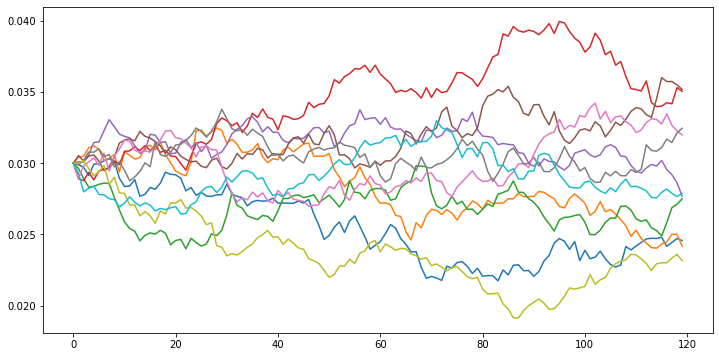

In [19]:
%matplotlib inline

cir(n_scenarios=10, sigma=.01).plot(figsize=(12,6), legend=False)
## 이자율의 변화 추이

In [25]:
# 위젯 추가

import ipywidgets as widgets
from IPython.display import display

def show_cir(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios).plot(legend=False, figsize=(12,6))
    
controls = widgets.interactive(show_cir,
                              n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=10),
                               a=(.01, 1, .01),
                               b=(.01, .2, .01),
                               sigma=(0, .5, .01),
                               r_0=(0, .3, .01)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.3, step=0.01), FloatSlider(value=0.5, d…

CIR모델로 zero coupon bond 가격 구하기

참고 : https://wikidocs.net/92488

t시간일 때 bond의 가격 P

$$ P(t,T) = A(t,T)e^{-B(t,T)r_{t}} $$

$$ A(t,T) = \left({\frac {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma^{2}}} $$

$$ B(t,T) = {\frac {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$

$$ h = {\sqrt{a^2+2 \sigma^{2}}} $$

$$ \tau = T-t $$

In [26]:
import math
def cir(n_years=10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    """
    CIR 모델 => 이자율, 가격
    """
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## For Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index=range(num_steps))
    prices = pd.DataFrame(data=prices, index=range(num_steps))
    
    return rates, prices

In [27]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,6))

controls = widgets.interactive(show_cir_prices,
                              n_scenarios=widgets.IntSlider(min=1, max=100, step=1, value=30),
                               a=(0, 1, 0.1),
                               b=(0, 0.5, 0.01),
                               sigma=(0, 0.5, 0.01),
                               r_0=(0, 0.15, 0.01)
                              )

display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

zero coupon bond는 만기일에는 모든 조건 상관없이 특정 가격에 수렴

In [67]:
a_0 = .75  ## 지금 가지고 있는 자산
rates, bond_prices = cir(n_years=10, r_0=.03, b=.03, n_scenarios=10)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])  ## 10년 짜리 할인채
zc_0 = pv(zcbond_10, r=.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices  ## 가지고 있는 채권의 가치
av_cash = a_0*(rates/12+1).cumprod()  ## cash를 가지고 있었을 경우 자산


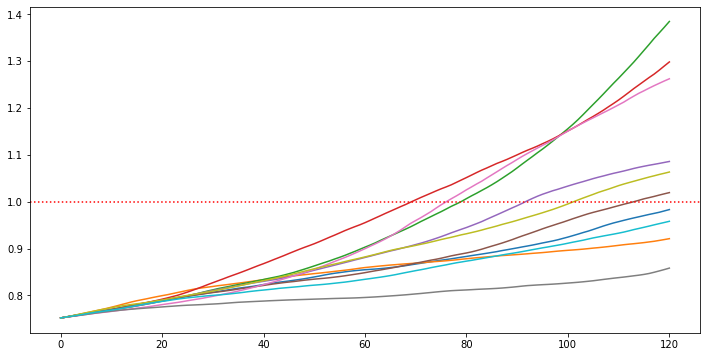

In [68]:
ax = av_cash.plot(legend=False, figsize=(12,6))
ax.axhline(y=1, color='red', linestyle=':')

이자율이 변할 때(CIR 모델), 현금만 들고 있는 경우의 자산 추이

처음 자산이 0.75, 10년 후 갚아야 하는 부채가 1인 경우

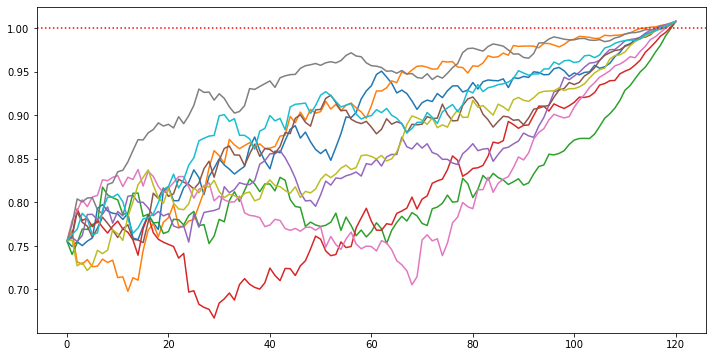

In [69]:
ax = av_zc_bonds.plot(legend=False, figsize=(12,6))
ax.axhline(y=1, color='red', linestyle=':')

할인채는 만기일에 모두 부채 상환 가능

그래프 모양만 보면 cash가 더 부드럽고 변동성 없어 보이지만, Funding ratio 관점에서는 cash가 더 risky(못 갚는 경우)하고 채권이 더 안전함

<AxesSubplot:>

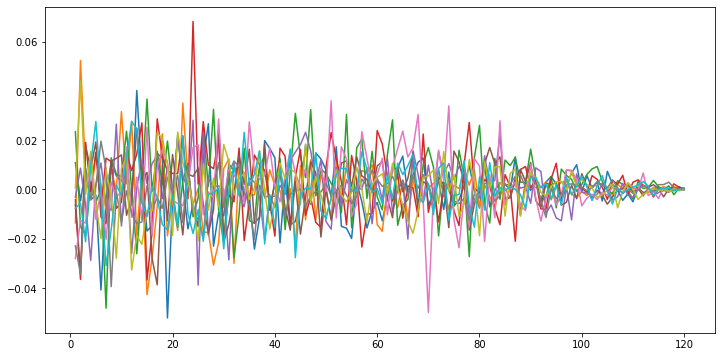

In [71]:
(av_cash/liabilities).pct_change().plot(legend=False, figsize=(12,6)) ## Funding ratio

<AxesSubplot:>

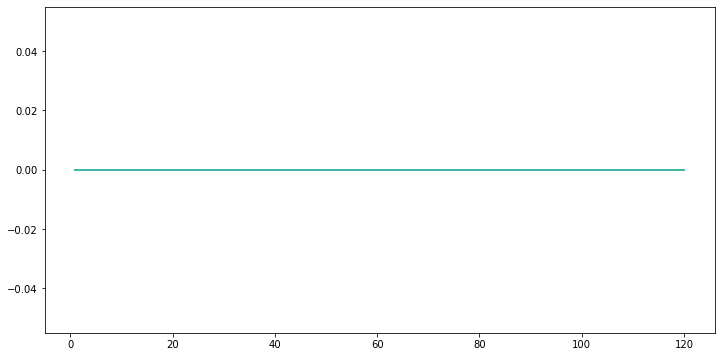

In [73]:
(av_zc_bonds/liabilities).pct_change().plot(legend=False, figsize=(12,6))  ## Funding ratio
## 채권과 부채의 움직임이 동일하기 때문에 ratio는 일정함!

In [80]:
a_0 = .75  ## 지금 가지고 있는 자산
rates, bond_prices = cir(n_years=10, r_0=.03, b=.03, n_scenarios=10000)
liabilities = bond_prices
zcbond_10 = pd.Series(data=[1], index=[10])  ## 10년 짜리 할인채
zc_0 = pv(zcbond_10, r=.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices  ## 가지고 있는 채권의 가치
av_cash = a_0*(rates/12+1).cumprod()  ## cash를 가지고 있었을 경우 자산

<AxesSubplot:label='9e54fdc1-42f1-4245-a722-d8d8843f5f6a'>

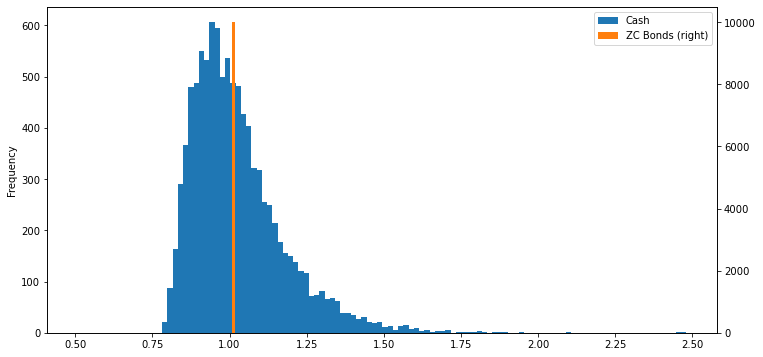

In [86]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label="Cash", figsize=(12,6), bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, secondary_y=True, legend=True)

결론: 부채 관리는 채권으로 하는게 좋다.

# GHP(Goal Hedging Portfolio) Construction with Duration Matching

In [94]:
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    하나의 채권에서 생기는 현금흐름
    """
    n_coupons = round(maturity*coupons_per_year)  ## 쿠폰 총 개수
    coupon_amt = principal*coupon_rate/coupons_per_year  ## 쿠폰 하나의 가격
    coupon_times = np.arange(1, n_coupons+1)  ## 쿠폰 나오는 횟수
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times) ## 쿠폰 데이터
    cash_flows.iloc[-1] += principal  ## 만기일에는 원금+쿠폰
    return cash_flows

def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    하나의 채권에서 생기는 현금흐름을 discount_rate을 고려한 현재가치로 환산
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)

In [93]:
bond_cash_flows(1)

1       0.25
2       0.25
3       0.25
4       0.25
5       0.25
6       0.25
7       0.25
8       0.25
9       0.25
10      0.25
11      0.25
12    100.25
dtype: float64

In [97]:
bond_price(1)

100.00000000000006

In [101]:
erk.bond_price(maturity=20, principal=1000, coupon_rate=0.05, coupons_per_year=2, discount_rate=0.04)

0    1136.777396
dtype: float64

In [102]:
rates = np.linspace(.01, .1, num=20)

In [141]:
price = erk.bond_price(10, 1000, .05, 2, rates)
price.index = rates
price

0.010000    1379.748383
0.014737    1326.762928
0.019474    1276.163298
0.024211    1227.833538
0.028947    1181.663651
0.033684    1137.549279
0.038421    1095.391400
0.043158    1055.096038
0.047895    1016.573997
0.052632     979.740605
0.057368     944.515473
0.062105     910.822268
0.066842     878.588497
0.071579     847.745306
0.076316     818.227287
0.081053     789.972298
0.085789     762.921290
0.090526     737.018147
0.095263     712.209532
0.100000     688.444741
dtype: float64

In [142]:
price = pd.DataFrame(data=price)
price

,0
0.010000,1379.748383
0.014737,1326.762928
0.019474,1276.163298
0.024211,1227.833538
0.028947,1181.663651
0.033684,1137.549279
0.038421,1095.391400
0.043158,1055.096038
0.047895,1016.573997
0.052632,979.740605


<AxesSubplot:>

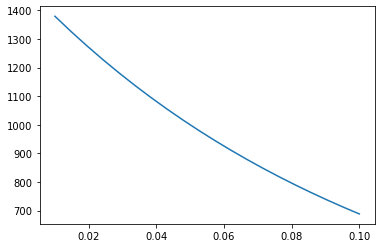

In [145]:
prices = [erk.bond_price(10, 1000, .05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(legend=False)

In [147]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [163]:
discounts = erk.discount(cf.index, .06/2)
discounts

,0
1,0.970874
2,0.942596
3,0.915142
4,0.888487
5,0.862609
6,0.837484


In [167]:
cf = pd.DataFrame(data=cf)

In [168]:
dcf = discounts*cf
dcf

,0
1,29.126214
2,28.277877
3,27.454250
4,26.654611
5,25.878264
6,862.608784


In [173]:
weights = dcf/dcf.sum()
weights

,0
1,0.029126
2,0.028278
3,0.027454
4,0.026655
5,0.025878
6,0.862609


In [190]:
(weights[0]*weights.index).sum()

5.579707187194534

In [197]:
def macaulay_duration(flows, discount_rate):
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)

In [225]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
macaulay_duration(liabilities, .04)

10.960799385088393

In [226]:
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)

In [227]:
md_10 = macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_20 = macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)

In [239]:
short_bond = bond_cash_flows(10, 1000, .05, 1)
long_bond = bond_cash_flows(20, 1000, .05, 1)
w_s = match_durations(liabilities, short_bond, long_bond, .04)
w_s

0.48263092069478974

금리가 오르면 채권 가격은 떨어지지만, Funding ratio 관점에서 보면

단기채의 Funding ratio 상승 // 장기채의 Funding ratio 하락

왜냐면, 금리가 하락하는 경우 채권 가격은 상승하지만 동시에 부채 가치도 상승함. 이때 장기채는 단기채보다 가격이 많이 상승하기 때문에 장기채의 Funding ratio는 상승.